In [1]:
import os 

os.chdir("app")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import BaggingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score

In [4]:
df = pd.read_csv("data/transactions.csv")

In [5]:
train = pd.read_csv("data/train.csv", index_col=0)

# TF-IDF model

In [6]:
df.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg


In [7]:
def preproc_amount(x):
    if x > 0:
        return np.log(1 + x)
    return -np.log(1 - x)

# df['amount'] = df['amount'].apply(preproc_amount)

In [8]:
Q3, Q1 = df['amount'].quantile(0.75), df['amount'].quantile(0.25)
iqr = Q3 - Q1

# df = df[(df['amount'] < Q3 + 1.5*iqr) & (df['amount'] > Q1 - 1.5*iqr)]

df = df[(df['amount'] > df['amount'].quantile(0.01)) & (df['amount'] < df['amount'].quantile(0.99))]

In [9]:
base_date = pd.to_datetime('2022-01-01')

df['trans_time'] = df['trans_time'].astype(str)
df[['days', 'time']] = df['trans_time'].str.split(' ', expand=True)
df['days'] = pd.to_timedelta(df['days'].astype(int), unit='D')
df['time'] = pd.to_timedelta(df['time'])
df['event_time'] = base_date + df['days'] + df['time']

df['hour'] = df['event_time'].dt.hour
df['minute'] = df['event_time'].dt.minute
df['day_of_week'] = df['event_time'].dt.day_of_week

df['night'] = (df['hour'] <= 6) & (df['hour'] >= 23)

df['amount_pos'] = df['amount'] * (df['amount']>=0) 
df['amount_neg'] = - df['amount'] * (df['amount']<0)

df['is_na_term_id'] = df['term_id'].isna()

In [10]:
def generate_pivot_features(df, col, value, aggfunc):
    pivot = df.pivot_table(values=[value], index=['client_id'], columns=[col], aggfunc=aggfunc)
    pivot.columns = [f'{col}_{v}_{value}_{aggfunc}' for _, v in pivot.columns]
    pivot = pivot.reset_index()

    return pivot

In [11]:
def generate_tfidf_features(df, col):
    bot = df.groupby('client_id')[col].apply(lambda x: list(x))
    corpus = [' '.join(map(str, x)) for x in bot]

    tfidf = TfidfVectorizer()
    tfidf.fit(corpus)

    tfidf_features = pd.DataFrame(
        tfidf.transform(corpus).A,
        columns=[f'tfidf_{col}_{k}' for k in tfidf.get_feature_names_out()]
    )
    tfidf_features['client_id'] = bot.index

    return tfidf_features

In [12]:
tfidf_features_mcc = generate_tfidf_features(df, 'mcc_code')
tfidf_features_type = generate_tfidf_features(df, 'trans_type')

In [13]:
mcc_amount = generate_pivot_features(df, 'mcc_code', 'amount', 'mean')

In [14]:
type_amount = generate_pivot_features(df, 'trans_type', 'amount_neg', 'mean')

In [15]:
day_of_week_features = generate_pivot_features(df, 'day_of_week', 'amount', 'mean')

In [16]:
hour_features = generate_pivot_features(df, 'hour', 'amount', 'mean')

In [17]:
amount_agg = df.groupby('client_id').agg({
    'amount_pos': ['mean', 'std', 'max'],
    'amount_neg': ['mean', 'std', 'max'],
    'amount': ['mean', 'std', 'max', 'min'],
    # 'is_na_term_id': ['mean']
}).reset_index()

amount_agg.columns = [f'{head}_{stat}' if stat != '' else head for head, stat in amount_agg.columns]

In [18]:
data = (
    tfidf_features_mcc 
    .merge(mcc_amount) 
    .merge(type_amount)
    .merge(tfidf_features_type) 
    .merge(day_of_week_features) 
    .merge(hour_features)
    .merge(amount_agg)
    .merge(train) 
)


In [19]:
X = data.drop(['client_id', 'gender'], axis=1)
y = data['gender']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

In [20]:
model = LGBMClassifier(n_estimators=500, max_depth=3, reg_alpha=15, reg_lambda=15, verbose=-1)
# model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])
# model = XGBClassifier(n_estimators=100, max_depth=3)
# model = Pipeline(
#     [
#         # ('pca', PCA(1500)), 
#         ('lgbm', LGBMClassifier(n_estimators=300, max_depth=5, reg_alpha=15, reg_lambda=15, verbose=-1))
#     ]
# )


model.fit(X_train.fillna(0), y_train)

LGBMClassifier(max_depth=3, n_estimators=500, reg_alpha=15, reg_lambda=15,
               verbose=-1)

In [21]:
roc_auc_score(y_train, model.predict_proba(X_train.fillna(0))[:, 1])

0.9389423232524311

In [22]:
roc_auc_score(y_valid, model.predict_proba(X_valid.fillna(0))[:, 1])

0.8812368223721934

In [23]:
model = BaggingClassifier(
    LGBMClassifier(n_estimators=500, max_depth=3, reg_alpha=15, reg_lambda=15, verbose=-1),
    n_estimators=10
)
model.fit(X_train, y_train)

BaggingClassifier(estimator=LGBMClassifier(max_depth=3, n_estimators=500,
                                           reg_alpha=15, reg_lambda=15,
                                           verbose=-1))

In [ ]:
import pickle

pickle.dump(model, open('lgbm_ensemble.pkl', "wb"))

AttributeError: 'LGBMClassifier' object has no attribute 'save'

In [107]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.948944123281604

In [108]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.881697322570685

In [80]:
res = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

In [81]:
f'{res.mean()} +- {res.std()}'

'0.876159568928893 +- 0.007369596593084425'

In [409]:
# mcc_amount_pos = generate_pivot_features(df, 'mcc_code', 'amount_pos', 'sum')
# mcc_amount_neg = generate_pivot_features(df, 'mcc_code', 'amount_neg', 'sum')
mcc_amount = generate_pivot_features(df, 'mcc_code', 'amount', 'sum')

# type_amount_pos = generate_pivot_features(df, 'trans_type', 'amount_pos', 'sum')
# type_amount_neg = generate_pivot_features(df, 'trans_type', 'amount_neg', 'sum')
type_amount = generate_pivot_features(df, 'trans_type', 'amount', 'sum')

In [410]:
day_of_week_features = generate_pivot_features(df, 'day_of_week', 'amount', 'sum')
hour_features = generate_pivot_features(df, 'hour', 'amount', 'sum')

In [695]:
amount_pos = df[df['amount'] > 0].groupby('client_id')['amount'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
amount_pos.columns = [f'amount_pos_{col}' if col != 'client_id' else col for col in amount_pos.columns]

amount_neg = df[df['amount'] <= 0].groupby('client_id')['amount'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
amount_neg.columns = [f'amount_neg_{col}' if col != 'client_id' else col for col in amount_neg.columns]

In [420]:
amount_agg = df.groupby('client_id').agg({
    'amount_pos': ['mean', 'std', 'max'],
    'amount_neg': ['mean', 'std', 'max'],
    # 'amount': ['mean', 'std', 'max', 'min'],
    'is_na_term_id': ['mean']
}).reset_index()

amount_agg.columns = [f'{head}_{stat}' if stat != '' else head for head, stat in amount_agg.columns]

In [61]:
tfidf_features_mcc = generate_tfidf_features(df, 'mcc_code')

In [126]:
tfidf_features_type = generate_tfidf_features(df, 'trans_type')

In [441]:
data = tfidf_features_mcc \
    .merge(tfidf_features_type) \
    .merge(day_of_week_features) \
    .merge(hour_features) \
    .merge(amount_neg) \
    .merge(amount_pos) \
    .merge(type_amount) \
    .merge(train)    

# .merge(part_of_day_features) \

# .merge(mcc_amount_pos) \
# .merge(mcc_amount_neg) \
# .merge(type_amount_pos) \
# .merge(type_amount_neg) \
# .merge(mcc_amount) \

# .merge(tfidf_features_mcc) \

In [442]:
X = data.drop(['client_id', 'gender'], axis=1)
y = data['gender']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

In [443]:
model = LGBMClassifier(n_estimators=500, max_depth=5, reg_alpha=15, reg_lambda=15, verbose=-1)
# model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])
# model = XGBClassifier(n_estimators=100, max_depth=3)
# model = Pipeline(
#     [
#         # ('pca', PCA(1500)), 
#         ('lgbm', LGBMClassifier(n_estimators=300, max_depth=5, reg_alpha=15, reg_lambda=15, verbose=-1))
#     ]
# )


model.fit(X_train.fillna(0), y_train)

LGBMClassifier(max_depth=5, n_estimators=500, reg_alpha=15, reg_lambda=15,
               verbose=-1)

In [444]:
roc_auc_score(y_train, model.predict_proba(X_train.fillna(0))[:, 1])

0.9647509285846

In [445]:
roc_auc_score(y_valid, model.predict_proba(X_valid.fillna(0))[:, 1])

0.8657350819115524

In [166]:
imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [167]:
imp.to_csv('importance.csv')

<BarContainer object of 559 artists>

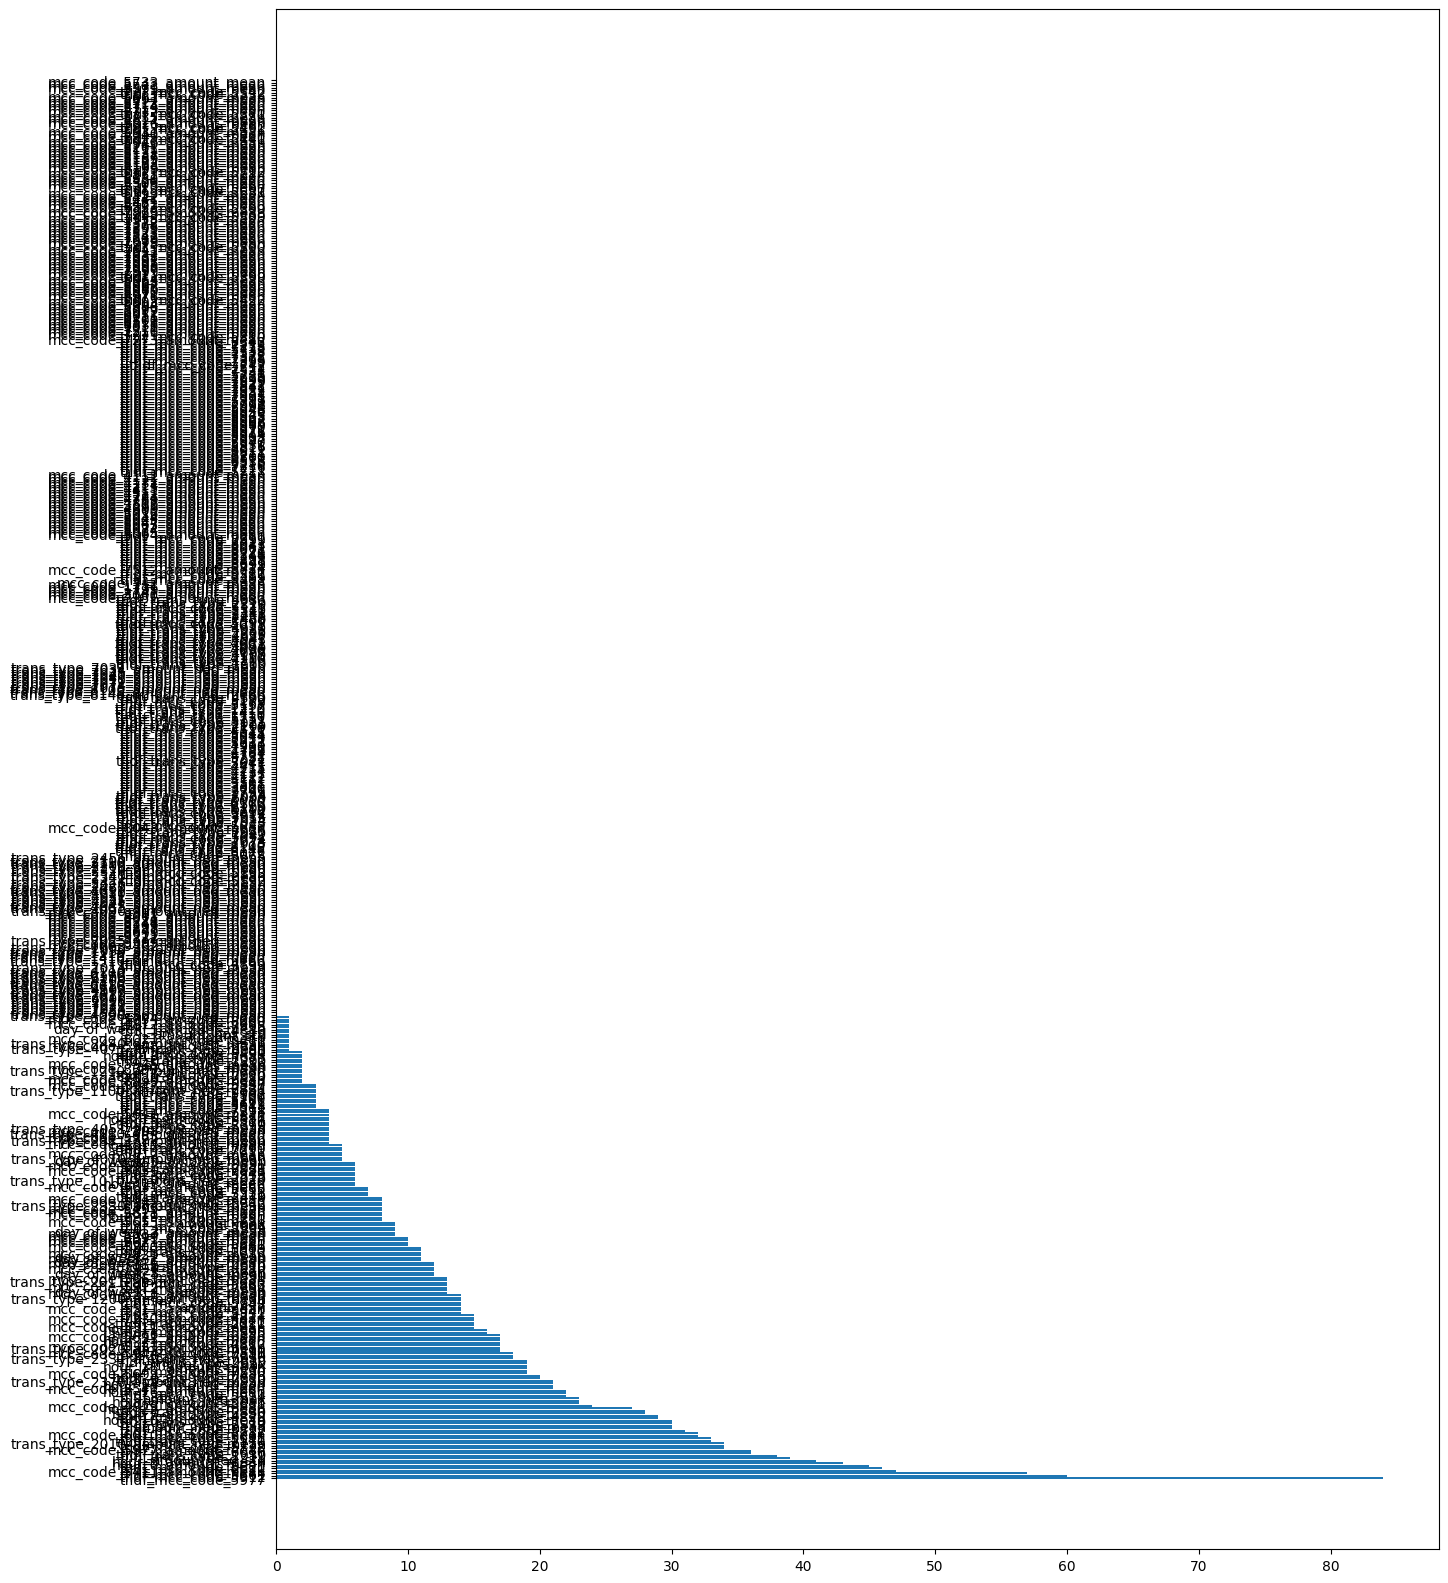

In [168]:
fig, ax = plt.subplots(figsize=(15, 20))

ax.barh(imp.index, imp)

# SVD

In [149]:
interaction_mcc = df.pivot_table(values='amount', index=['client_id'], columns=['mcc_code'], aggfunc='count').fillna(0)

In [150]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
svd.fit(interaction_mcc)

TruncatedSVD(n_components=50)

In [151]:
svd_mcc_features = pd.DataFrame(svd.transform(interaction_mcc))
svd_mcc_features['client_id'] = interaction_mcc.index

In [152]:
# interaction_term = df.pivot_table(values='amount', index=['client_id'], columns=['term_id'], aggfunc="count").fillna(0)

In [153]:
# svd = TruncatedSVD(n_components=30)
# svd.fit(interaction_term)

In [154]:
# svd_term_features = pd.DataFrame(svd.transform(interaction_term))
# svd_term_features['client_id'] = interaction_term.index 

In [155]:
interaction_type = df.pivot_table(values='amount', index=['client_id'], columns=['trans_type'], aggfunc="count").fillna(0)

In [156]:
svd_type = TruncatedSVD(n_components=30)
svd_type.fit(interaction_type)

TruncatedSVD(n_components=30)

In [157]:
svd_type_features = pd.DataFrame(svd_type.transform(interaction_type))
svd_type_features['client_id'] = interaction_type.index

In [163]:
data = svd_mcc_features.merge(train) # .merge(svd_type_features, on='client_id')

In [164]:
X = data.drop(['client_id', 'gender'], axis=1)
y = data['gender']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

In [201]:
model = LGBMClassifier(n_estimators=300, max_depth=5, reg_alpha=15, reg_lambda=15, verbose=-1)
# model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000))])

model.fit(X_train.fillna(0), y_train)

LGBMClassifier(max_depth=5, n_estimators=300, reg_alpha=15, reg_lambda=15,
               verbose=-1)

In [202]:
roc_auc_score(y_train, model.predict_proba(X_train.fillna(0))[:, 1])

0.9424844126784123

In [203]:
roc_auc_score(y_valid, model.predict_proba(X_valid.fillna(0))[:, 1])

0.8170252745798599

# Amount and mcc_code

In [7]:
top_mcc = list(df['mcc_code'].value_counts().iloc[:80].index)

In [50]:
res = []

for cl_id in tqdm(df['client_id'].unique()):
    agg = df[df['client_id'] == cl_id].groupby('mcc_code')['mcc_code'].agg(['count', 'mean', 'min', 'max', 'std'])
    
    mcc_not_used = [mcc for mcc in top_mcc if mcc not in agg.index]

    new_agg = agg.to_dict('records') + [{k: 0 for k in ['count', 'mean', 'min', 'max', 'std']}] * len(mcc_not_used)
    new_agg = pd.DataFrame(new_agg, index=list(agg.index) + mcc_not_used)
    
    new_agg = pd.melt(new_agg.loc[top_mcc].reset_index(), id_vars='index')
    new_agg['feature_name'] = new_agg['index'].astype('str') + '_' + new_agg['variable'] 

    features = dict(zip(new_agg['feature_name'], new_agg['value']))

    features['client_id'] = cl_id

    res.append(features)

100%|██████████| 7560/7560 [25:29<00:00,  4.94it/s]


In [51]:
pd.DataFrame(res).to_csv('aggregates.csv', index=False)

In [94]:
df_train = pd.read_csv('aggregates.csv')

In [95]:
df = df_train.merge(train).merge(amount_agg)

In [97]:
X = df.drop(['client_id', 'gender'], axis=1)
y = df['gender']

In [98]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)


In [99]:
X_train

,6011_count,4814_count,5411_count,6010_count,4829_count,5499_count,5541_count,5912_count,5331_count,5812_count,...,8043_std,7523_std,7298_std,5948_std,5714_std,7999_std,mean,std,max,min
2436,122.0,87.0,65.0,85.0,25.0,0.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.243151,847.621600,5062.54,-4339.40
746,152.0,49.0,16.0,6.0,6.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1146.964858,3226.350936,4339.62,-28925.15
6307,17.0,5.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-11673.800000,12588.600114,-65.04,-46207.57
2095,128.0,39.0,18.0,6.0,17.0,168.0,1.0,5.0,64.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-241.970464,1468.598476,13016.58,-7592.60
4541,123.0,142.0,185.0,1.0,0.0,2.0,4.0,28.0,2.0,3.0,...,NaN,0.0,NaN,NaN,0.0,0.0,-17.355366,2116.294729,18079.04,-10846.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,69.0,90.0,11.0,20.0,35.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1975.513099,7262.505368,36155.44,-36879.15
5226,39.0,47.0,101.0,13.0,1.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-141.047116,5038.689879,44471.62,-43388.10
5390,21.0,36.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-2709.668983,3941.531305,-71.30,-10847.82
860,149.0,438.0,216.0,1.0,4.0,27.0,0.0,13.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-198.707212,549.316698,75.59,-5423.34


In [117]:
# model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
model = LGBMClassifier(n_estimators=500, reg_alpha=5, reg_lambda=10, verbose=-1)

model.fit(X_train.fillna(0), y_train)

LGBMClassifier(n_estimators=500, reg_alpha=5, reg_lambda=10, verbose=-1)

In [118]:
roc_auc_score(y_train, model.predict_proba(X_train.fillna(0))[:, 1])

0.9869906534232561

In [119]:
roc_auc_score(y_valid, model.predict_proba(X_valid.fillna(0))[:, 1])

0.8574516830378959

<BarContainer object of 404 artists>

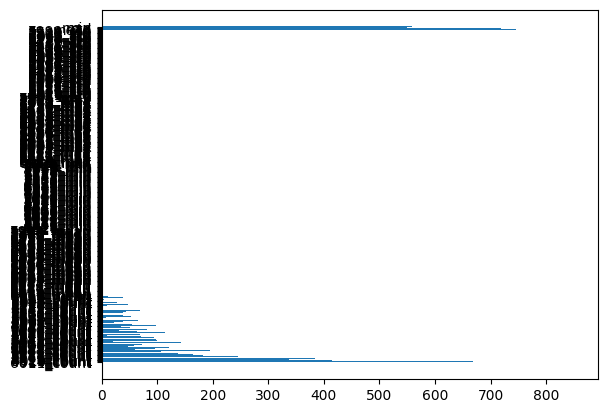

In [116]:
plt.barh(X_train.columns, model.feature_importances_)